# Deep Learning Fundamentals - LU08 Exercise

## 9A.0 RNN Example - Sentimental Analysis

Loads the Reuters newswire classification dataset. You can read up more at https://keras.io/api/datasets/reuters/

This is a dataset of 11,228 newswires from Reuters, labeled over 46 topics.

This was originally generated by parsing and preprocessing the classic Reuters-21578 dataset, but the preprocessing code is no longer packaged with Keras.

Each newswire is encoded as a list of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".

As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.

In [1]:
from keras.datasets import reuters

# Number of words to consider as features as the dataset only consider top 10,000 words. 
max_features = 10000  
maxlen = 500  # Cut texts after this number of words (among top max_features most common words)
batch_size = 64

print('Loading data...\n')

# Loads the Reuters newswire classification dataset by keeping the 10000 most frequent words
# The return are list of sequences, which are list of indexes (integers).
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_features)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Loading data...

2121728/2110848 [==============================] - 0s 0us/step
x_train shape: (8982,)
x_test shape: (2246,)
y_train shape: (8982,)
y_test shape: (2246,)


## 9A.1 Print out some sample data

In [8]:
import random

i = random.randint(0, x_train.shape[0])

# Print the words in integers for the topic
print('X_train: ', x_train[i])

# Print the topic number
print('y_train: ', y_train[i])

X_train:  [1, 56, 3170, 1466, 247, 71, 157, 1822, 42, 943, 155, 139, 46, 8, 16, 200, 6, 337, 1348, 324, 3170, 1466, 901, 71, 13, 251, 18, 15, 197, 527, 6, 897, 9, 1135, 518, 3170, 1466, 75, 8, 16, 33, 219, 980, 18, 15, 6, 7079, 6408, 3353, 5, 25, 595, 79, 50, 33, 30, 471, 22, 1848, 2, 9, 271, 2, 2, 33, 538, 9, 4567, 3170, 1466, 901, 480, 4, 1101, 3170, 1466, 64, 10, 5352, 2637, 150, 46, 13, 4, 155, 177, 273, 207, 156, 4, 49, 638, 25, 943, 396, 4500, 7, 207, 4, 49, 8, 25, 2, 532, 304, 40, 85, 3274, 445, 18, 15, 1060, 4, 211, 133, 6, 525, 7, 93, 75, 1343, 13, 2836, 5, 4, 4359, 628, 18, 150, 60, 222, 3170, 1466, 8, 4, 304, 75, 40, 200, 6, 219, 10, 222, 5, 628, 18, 15, 6, 2, 49, 149, 50, 23, 279, 20, 324, 27, 3170, 1466, 3170, 1466, 384, 8, 16, 200, 6, 438, 4, 1004, 376, 20, 5, 2, 16, 535, 45, 414, 595, 17, 12]
y_train:  3


## 9A.2 Decode (reverse) the data

In [ ]:
# Retrieves a dictionary mapping words to their index in the Reuters dataset.
vocab_dict = reuters.get_word_index()

# Inverse the dict for lookup via index
vocab_dict = dict((v, k) for k, v in vocab_dict.items())

# Randomly select an index and try to see if can find the word in the dictionary. 
i = random.randint(0, x_train.shape[0])
print('x_train: ', x_train[i])
print('y_train: ', y_train[i])
print()
# For each index(number) in the selected training data, if found the index in dictionary, retrieve the word, otherwise, marked as XXX
# XXX appear when index is 0 for unknown word in the reuters' database
txt = [vocab_dict[idx] if idx in vocab_dict else "XXX" for idx in x_train[i]]
print(txt)

565248/550378 [==============================] - 0s 0us/step
x_train:  [1, 651, 1293, 6929, 4611, 195, 9, 621, 374, 1080, 5, 216, 71, 118, 827, 215, 4, 49, 23, 189, 3639, 7, 332, 6, 2615, 10, 2620, 5, 1068, 201, 24, 33, 1872, 7, 1068, 497, 1672, 6929, 487, 6, 658, 194, 783, 51, 8, 42, 1020, 461, 30, 1810, 7, 10, 804, 407, 36, 75, 487, 6, 452, 552, 4, 205, 41, 30, 170, 27, 216, 71, 58, 234, 1238, 9, 1197, 81, 10, 396, 49, 7, 50, 216, 976, 10, 1243, 310, 1068, 497, 1672, 23, 324, 27, 7260, 2422, 298, 56, 2, 17, 12]
y_train:  4

['the', 'area', 'access', 'mild', 'richfield', 'export', '3', 'start', 'loan', 'gnp', 'said', 'pay', 'profit', 'week', 'decided', 'business', 'in', 'this', 'cts', 'west', 'implications', 'a', 'outstanding', 'and', 'loading', 'for', 'quite', 'said', 'improvement', 'central', 'by', 'he', 'material', 'a', 'improvement', 'open', 'bushels', 'mild', 'reagan', 'and', 'selling', 'cash', 'east', 'last', 'mln', 'not', 'similar', 'payments', 'will', 'smith', 'a', 'for', 'res

## 9A.3 Preprocess the input data

In [ ]:
from keras.preprocessing import sequence

# pad_sequences is used to ensure that all sequences in a list have the same length. 
# By default this is done by padding 0 in the beginning of each sequence until each sequence has the same length as the longest sequence.
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (8982, 500)
x_test shape: (2246, 500)


In [ ]:
x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

## 9A.4 Print out some processed data

In [ ]:
i = random.randint(0, x_train.shape[0])
print(x_train[i])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [ ]:
len(x_train[i])

500

## 9A.5 Preprocess the output data (One-hot encoding)

In [ ]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (8982, 46)
y_test shape: (2246, 46)


## 9A.6 Build the RNN model

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
from keras.layers import Dense

model = Sequential()
# Create an embedding layer that is used for NN on text data. It requires input data to be integer encoded, so that each word is represented by a unique integer
# The following creates an embedding layer with a list of 10000 words, which will produce and output dimension of vector of size 64.
model.add(Embedding(max_features, 64, input_length=500))

# A fully connected RNN where the output is fed back to the input
# 64 output space, return_sequences=True implies output will be whole sequence
model.add(SimpleRNN(32, activation='tanh', return_sequences=True))
model.add(SimpleRNN(32, activation='tanh'))

# Final 46 topic classifier
model.add(Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 64)           640000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 500, 32)           3104      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 46)                1518      
                                                                 
Total params: 646,702
Trainable params: 646,702
Non-trainable params: 0
_________________________________________________________________
None


## 9A.7 Train the model

In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.3)

Epoch 1/10
50/50 [==============================] - 52s 856ms/step - loss: 2.7444 - accuracy: 0.3650 - val_loss: 2.3449 - val_accuracy: 0.3959
Epoch 2/10
50/50 [==============================] - 45s 894ms/step - loss: 2.1271 - accuracy: 0.4934 - val_loss: 2.1485 - val_accuracy: 0.4787
Epoch 3/10
50/50 [==============================] - 42s 849ms/step - loss: 1.9308 - accuracy: 0.5155 - val_loss: 1.9558 - val_accuracy: 0.5113
Epoch 4/10
50/50 [==============================] - 43s 865ms/step - loss: 1.6668 - accuracy: 0.5701 - val_loss: 2.3899 - val_accuracy: 0.3900
Epoch 5/10
50/50 [==============================] - 43s 857ms/step - loss: 1.4030 - accuracy: 0.6507 - val_loss: 1.8718 - val_accuracy: 0.5547
Epoch 6/10
50/50 [==============================] - 43s 865ms/step - loss: 1.1579 - accuracy: 0.7204 - val_loss: 1.8608 - val_accuracy: 0.5455
Epoch 7/10
50/50 [==============================] - 42s 841ms/step - loss: 0.9681 - accuracy: 0.7773 - val_loss: 1.9468 - val_accuracy: 0.5195

## 9A.8 Plot the training and loss curve

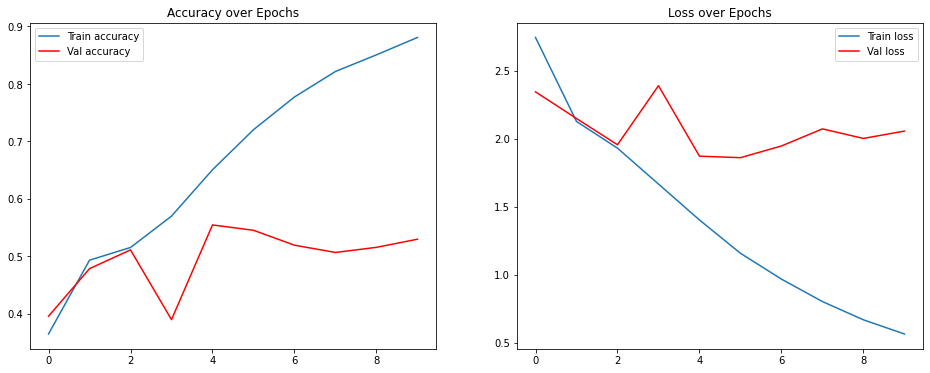

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Train accuracy')
plt.plot(epochs, val_acc, color = 'red', label='Val accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Train loss')
plt.plot(epochs, val_loss, color = 'red', label='Val loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

---
Is this overfitting? Not necessary. Is due to the **Vanishing / Exploding Gradients**. The training is very well to the current data but not very far back in time. 
The high validation loss is due to the limitation of RNN. For the next lab, you will see how Long-Short Term Memory (LSTM) improves RNN.